In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Fully-connected neural network class for predicting local stiffness matrix from triangle's coordinates
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

class StiffnessPredictor_1(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_1 = nn.Linear(10, 1024)
        self.bn_1     = nn.BatchNorm1d(1024)

        self.linear_2 = nn.Linear(1024, 2048)
        self.bn_2     = nn.BatchNorm1d(2048)

        self.linear_3 = nn.Linear(2048, 1024)
        self.bn_3     = nn.BatchNorm1d(1024)

        self.linear_4 = nn.Linear(1024, 36)

        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.linear_1(x)
        x = self.bn_1(x)
        x = self.activation(x)

        x = self.linear_2(x)
        x = self.bn_2(x)
        x = self.activation(x)
        
        x = self.linear_3(x)
        x = self.bn_3(x)
        x = self.activation(x)

        x = self.linear_4(x)

        return x


In [3]:
 # Training routine
 # - - - - - - - - -

def train(model, batches, lr, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr)
    loss_func = nn.MSELoss()
    loss_hist = []

    for i in range(n_epochs):
        print(f' * * * Epoch {i+1}/{n_epochs} * * * ')

        for batch in batches:
            coords, matricies = batch
            coords    = torch.FloatTensor(coords)
            matricies = torch.FloatTensor(matricies)

            predict = model(coords)
            loss = loss_func(predict, matricies)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_hist.append(loss.item())

    return loss_hist

In [4]:
import math

def triangle_angles(triangle):
    x1, y1, x2, y2, x3, y3 = triangle
    # Calculate lengths of the sides using the distance formula
    a = np.sqrt((x2 - x3)**2 + (y2 - y3)**2)
    b = np.sqrt((x1 - x3)**2 + (y1 - y3)**2)
    c = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    # Calculate angles using the law of cosines
    angle_A = math.acos((b**2 + c**2 - a**2) / (2 * b * c))
    angle_B = math.acos((a**2 + c**2 - b**2) / (2 * a * c))
    angle_C = math.acos((a**2 + b**2 - c**2) / (2 * a * b))

    return angle_A, angle_B, angle_C


def triangle_area(triangle):
    x1, y1, x2, y2, x3, y3 = triangle
    area = 0.5 * abs(x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))
    return area


def node_shifts(triangle):
    x1, y1, x2, y2, x3, y3 = triangle

    centroid_x = (x1 + x2 + x3)/3
    centroid_y = (y1 + y2 + y3)/3

    x1 -= centroid_x
    y1 -= centroid_y
    x2 -= centroid_x
    y2 -= centroid_y
    x3 -= centroid_x
    y3 -= centroid_y

    return [x1, y1, x2, y2, x3, y3]

In [5]:
# Loading data, splitting to train & test, forming bacthes
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

filename_K = 'K_data.pkl'
filename_x = 'X_data.pkl'

with open(filename_K, 'rb') as f:
    K_data = pickle.load(f)

with open(filename_x, 'rb') as f:
    x_data = pickle.load(f)

train_frac = 0.9
train_N    = int(len(K_data)*train_frac)
batch_size = 32

K_train = K_data[:train_N]
K_test  = K_data[train_N:]

x_train = x_data[:train_N]
x_test  = x_data[train_N:]


# Forming features
for i, x in enumerate(x_train):
    
    angle_1, angle_2, angle_3 = triangle_angles(x)
    area = triangle_area(x)
    x1, y1, x2, y2, x3, y3 = node_shifts(x)

    x_train[i] = [angle_1, angle_2, angle_3, area, x1, y1, x2, y2, x3, y3]

In [6]:

batches = []
N_batches = len(K_train) // batch_size

np.random.seed(40)

for i in range(N_batches):
    batch_x = []
    batch_K = []

    for j in range(batch_size):
        idx = np.random.randint(0, len(x_train)-1)
        batch_x.append(x_train[idx])
        batch_K.append(K_train[idx].flatten())

    batches.append((np.array(batch_x), np.array(batch_K)))


In [7]:
model = StiffnessPredictor_1()
loss_history = []

In [8]:
# Training model
# - - - - - - - -
loss_history += train(model, batches[:], 1e-4, 3)
loss_history += train(model, batches[:], 1e-6, 1)

 * * * Epoch 1/3 * * * 
 * * * Epoch 2/3 * * * 
 * * * Epoch 3/3 * * * 
 * * * Epoch 1/1 * * * 


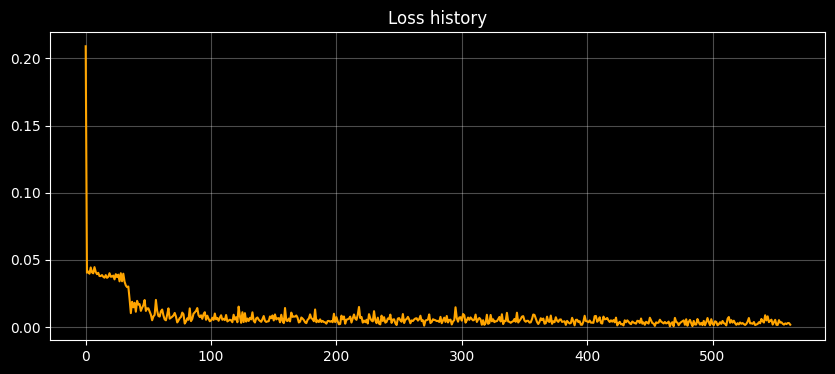

In [42]:
plt.style.use('dark_background')
plt.figure(figsize = (10, 4))

plt.plot(loss_history[::40], color = 'orange')

plt.grid(color = 'white', alpha = 0.3)
plt.title('Loss history')
plt.show()

In [10]:
# Test evaluation
# - - - - - - - - -

K_probes = []

i = 0
model.eval()
with torch.no_grad():
    for x, K in zip(x_test, K_test):
        i += 1

        angle_1, angle_2, angle_3 = triangle_angles(x)
        area = triangle_area(x)
        x1, y1, x2, y2, x3, y3 = node_shifts(x)

        x_inp = [angle_1, angle_2, angle_3, area, x1, y1, x2, y2, x3, y3]

        x_inp = torch.FloatTensor(x_inp)
        K_probe = model(x_inp.reshape(1, 10)).detach()
        
        K_probes.append(K_probe.reshape(6, 6))

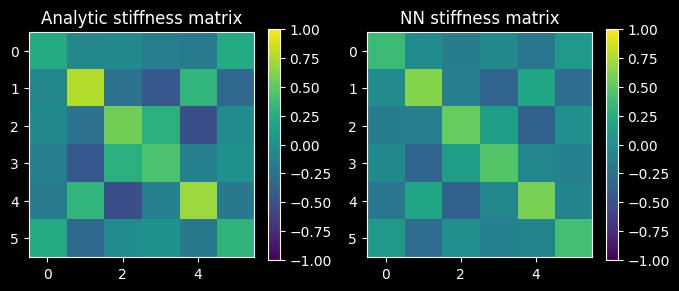

In [31]:
idx = 82

fig, axes = plt.subplots(1, 2, figsize = (8, 4))

pos0 = axes[0].imshow(K_test[idx], vmin = -1, vmax = 1)
pos1 = axes[1].imshow(np.array(K_probes[idx]), vmin = -1, vmax = 1)

fig.colorbar(pos0, shrink = 0.75)
fig.colorbar(pos1, shrink = 0.75)

axes[0].set_title('Analytic stiffness matrix')
axes[1].set_title('NN stiffness matrix')

plt.show()

In [12]:
# Calculating mean relative error 
# - - - - - - - - - - - - - - - - 

errors = []
for Kt, Kp in zip(K_test, K_probes):
    err = np.mean(np.abs(Kt - np.array(Kp))) / np.mean(np.abs(Kt))
    errors.append(err)

errors = np.array(errors)
print(f'Mean relative error in stiffness: {100*np.mean(errors):.4f}%')

Mean relative error in stiffness: 8.1572%


In [43]:
# Saving model weights
# - - - - - - - - - - -

filename = 'Stiffness_Predictor_v1.pth'
torch.save(model.state_dict(), filename)